In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import random

## P5.2  (1 point)

`C = p` </br>
Check the above analytical result by simulation

In [19]:
N = 100
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  

for p in p_values:
    G = nx.erdos_renyi_graph(N, p)
    avg_clustering = nx.average_clustering(G)
    print(f"p = {p}, C = {avg_clustering}")


p = 0.1, C = 0.09094463053286579
p = 0.2, C = 0.20862309362536852
p = 0.3, C = 0.2927166298426099
p = 0.4, C = 0.39729172332972823
p = 0.5, C = 0.5066622350057054
p = 0.6, C = 0.589666276018446
p = 0.7, C = 0.7091093957322901
p = 0.8, C = 0.803797902072914
p = 0.9, C = 0.8989894124577782


## P5.3 (2 points)

ER model generalisation

In [20]:
num_communities = 4
nodes_per_community = 20
total_nodes = num_communities * nodes_per_community

p_intra = 0.5  
p_inter = 0.05  

community_sizes = [nodes_per_community] * num_communities

prob_matrix = [
    [p_intra if community_1 == community_2 else p_inter 
        for community_2 in range(num_communities)] 
            for community_1 in range(num_communities)
    ]

pprint(prob_matrix)

[[0.5, 0.05, 0.05, 0.05],
 [0.05, 0.5, 0.05, 0.05],
 [0.05, 0.05, 0.5, 0.05],
 [0.05, 0.05, 0.05, 0.5]]


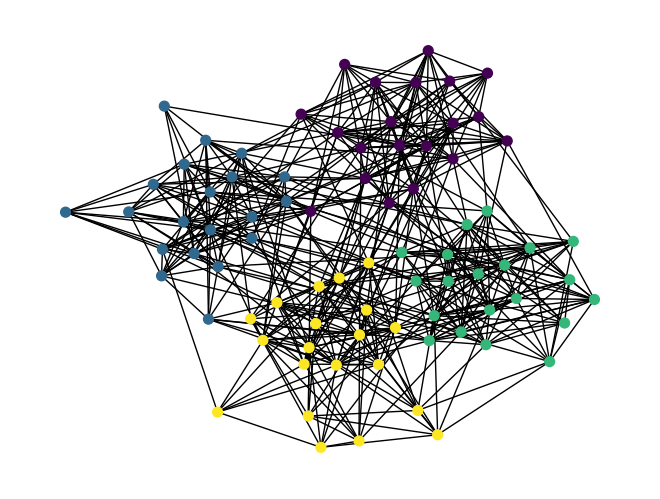

In [13]:
G = nx.stochastic_block_model(community_sizes, prob_matrix, seed=42)

pos = nx.spring_layout(G, seed=42, k=0.2)  
colors = []

for community in range(num_communities):
    colors.extend([community] * nodes_per_community)  

nx.draw(G, pos, node_color=colors, node_size=50)

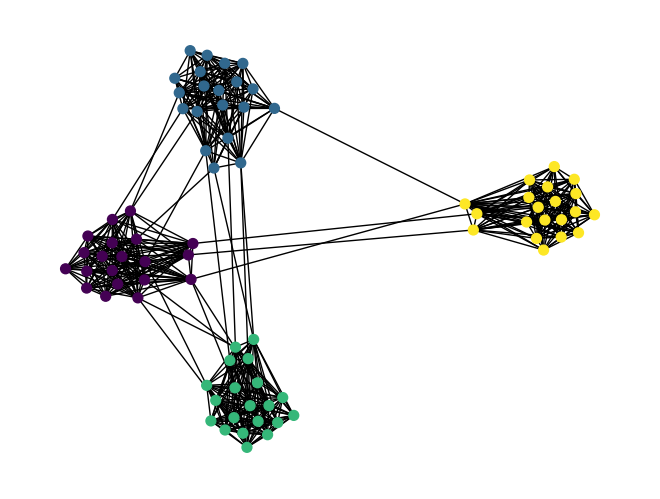

In [21]:
# different parameters
p_intra = 0.8  
p_inter = 0.01  

community_sizes = [nodes_per_community] * num_communities

prob_matrix = [
    [p_intra if community_1 == community_2 else p_inter 
        for community_2 in range(num_communities)] 
            for community_1 in range(num_communities)
    ]

G = nx.stochastic_block_model(community_sizes, prob_matrix, seed=42)

pos = nx.spring_layout(G, seed=42, k=0.2)  
colors = []

for community in range(num_communities):
    colors.extend([community] * nodes_per_community)  

nx.draw(G, pos, node_color=colors, node_size=50)

## P5.4 (1.5 points)

Draw a graph of the averaged coefficient of clustering of the WS
network against its parameter `p`.

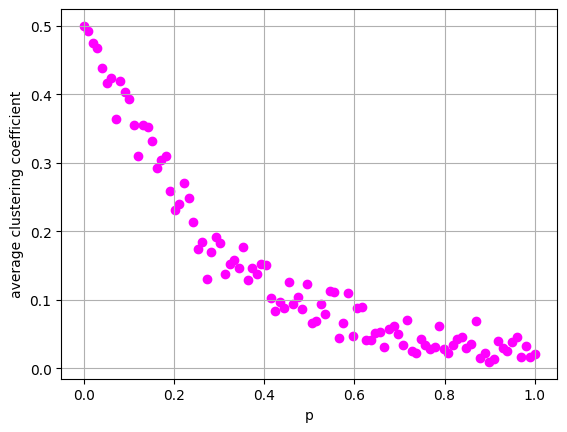

In [22]:
N = 100  
k = 5  
p_values = np.linspace(0, 1, 100)  

clustering_coefficients = []

for p in p_values:
    G = nx.watts_strogatz_graph(N, k, p)
    
    avg_clustering = nx.average_clustering(G)
    clustering_coefficients.append(avg_clustering)

plt.scatter(p_values, clustering_coefficients, marker='o', color='fuchsia')
plt.xlabel("p")
plt.ylabel("average clustering coefficient")
plt.grid(True)


## P5.6 (2.5 points)

Implement configuration model and test when the procedure
converge.

In [53]:
def configuration_model(degree_sequence, max_iterations=1000, retry_limit=10):

    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")
    
    stubs = []
    for node, degree in enumerate(degree_sequence):
        stubs.extend([(node, idx) for idx in range(degree)])  

    for iteration in range(max_iterations):
        random.shuffle(stubs)
        edges = []
        retry_count = 0
        
        while retry_count < retry_limit:
            success = True
            edges.clear()
            
            for i in range(0, len(stubs), 2):
                (u, u_idx), (v, v_idx) = stubs[i], stubs[i + 1]
                if u == v or (u, v) in edges or (v, u) in edges:
                    success = False
                    retry_count += 1
                    break
                edges.append((u, v))
            
            if success:
                G = nx.Graph()
                G.add_edges_from(edges)
                
                
                if [G.degree(n) for n in sorted(G.nodes())] == degree_sequence:
                    return G, iteration + 1
            random.shuffle(stubs)
    
    return None, max_iterations

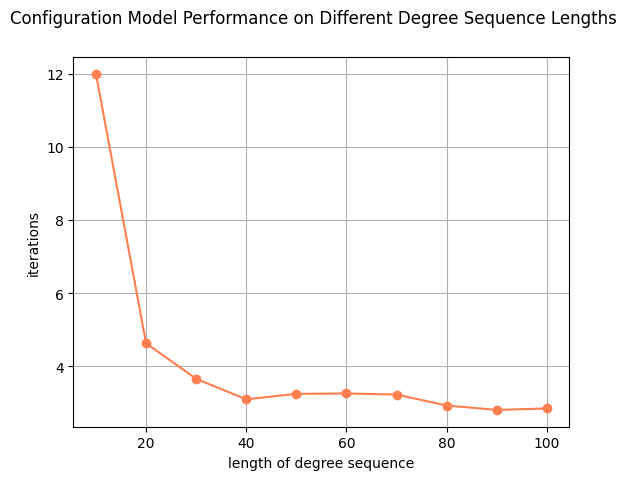

In [ ]:
sequence_lengths = list(range(10, 101, 10))  
num_trials = 100 
max_iterations = 1000 

max_degree = 5

results = {
    "length": [],
    "success_rate": [],
    "avg_iterations": [],
}


for length in sequence_lengths:
    successes = 0
    total_iterations = 0
    for _ in range(num_trials):
        degree_sequence = [random.randint(1, max_degree) for _ in range(length)]
        if sum(degree_sequence) % 2 != 0:
            degree_sequence[random.randint(0, length - 1)] += 1

        G, iterations = configuration_model(degree_sequence, max_iterations)

        if G is not None:
            successes += 1
            total_iterations += iterations

    results["length"].append(length)
    results["success_rate"].append(successes / num_trials)
    results["avg_iterations"].append(total_iterations / successes if successes > 0 else max_iterations)


plt.plot(results["length"], results["avg_iterations"], marker='o', color='coral', label="Avg. Convergence Iterations")
plt.xlabel("length of degree sequence")
plt.ylabel("iterations")
plt.grid(True)

plt.show()


## P5.7 (2.5 points)

Partition Function Z: 3634366593198.714


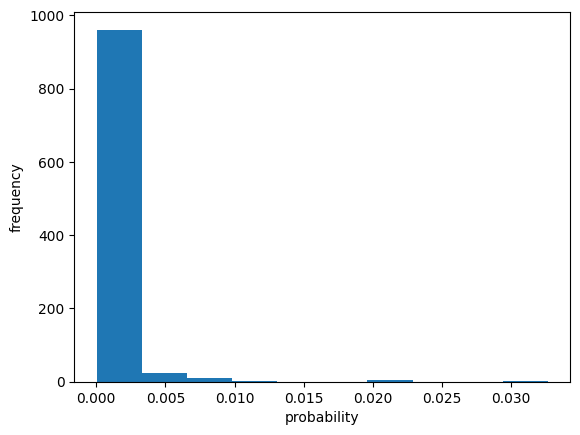

In [10]:
def hamiltonian_energy(G, alpha=1.0, gamma=1.0):
    E = G.number_of_edges()
    T = sum(nx.triangles(G).values()) / 3
    return -alpha * E - gamma * T


def partition_function(graphs, beta=1.0, alpha=1.0, gamma=1.0):
    Z = 0
    for G in graphs:
        H = hamiltonian_energy(G, alpha=alpha, gamma=gamma)
        Z += np.exp(-beta * H)
    return Z


def probability_distribution(graphs, Z, beta=1.0, alpha=1.0, gamma=1.0):
    probabilities = []
    for G in graphs:
        H = hamiltonian_energy(G, alpha=alpha, gamma=gamma)
        P = np.exp(-beta * H) / Z
        probabilities.append(P)
    return probabilities


beta = 1.0  
alpha = 1.0
gamma = 0.5
N = 10
N_edges = 18
num_graphs = 1000

graphs = []

for _ in range(num_graphs):
    graphs.append(nx.gnm_random_graph(N, N_edges))


Z = partition_function(graphs, beta=beta, alpha=alpha, gamma=gamma)

probabilities = probability_distribution(graphs, Z, beta=beta, alpha=alpha, gamma=gamma)

print(f"Partition Function Z: {Z}")



plt.hist(probabilities)
plt.xlabel("probability")
plt.ylabel("frequency")
plt.show()

